# Natural Language Processing

O objetivo deste projeto é a criação de um modelo de Machine Learning de classificação utilizado o processamento de linguagem natural. O modelo irá classificar os comentários em três classes: "Positivo", "Negativo" e "Neutro". O conjunto de comentários negativos possui um alto valor de informação para empresas, podendo ser utilizado como feedback de melhoria e/ou base de dados para análise de causa raiz. 

## 1. Importando Bibliotecas

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk import tokenize, RSLPStemmer, FreqDist, tokenize
from nltk.corpus import stopwords
from nltk.lm import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud
from string import punctuation


from utils.regex_utils import *
from utils.stopword_utils import RemoverStopwords
from utils.normalize_utils import ProcessoNormalizacao
from utils.stemming_utils import ProcessoStemming
from utils.features_extract import ExtracaoFeatures
from utils.n_grams_utils import ngrams_count
from utils.wordcloud_utils import nuvem_palavras

## 2. Leitura dos dados

O projeto foi desenvolvido utilizado um conjunto de dados público de e-commerce brasileiro de pedidos feitos na Olist Store, a maior loja de departamentos dos marketplaces brasileiros. A Olist conecta pequenas empresas de todo o Brasil a canais sem complicações e com um único contrato. Esses comerciantes podem vender seus produtos através da Olist Store e enviá-los diretamente aos clientes usando os parceiros de logística da Olist. O dataset possui informações de 100 mil pedidos de 2016 a 2018 feitos em vários marketplaces no Brasil. 

A base de dados de reviews foi construída a partir compras de produtos por clientes na Olist Store. Assim que o cliente recebe o produto, ou vence a data prevista de entrega, o cliente recebe uma pesquisa de satisfação por e-mail onde pode dar uma nota da experiência de compra e anotar alguns comentários.

In [3]:
dataset = pd.read_csv('order_reviews.csv', sep=';')

In [4]:
dataset.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


## 3. Compreensão de dados

### 3.1. Analise de dados faltantes (Null)

In [5]:
dataset.drop(['review_id', 'review_creation_date', 'review_answer_timestamp', 'review_comment_title', 'order_id'], axis=1, inplace=True)

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_score            99224 non-null  int64 
 1   review_comment_message  40977 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


In [7]:
# Retirando o valores Null de reviews
dataset = dataset.dropna()
dataset = dataset.reset_index(drop=True)
dataset.shape

(40977, 2)

In [8]:
dataset.head()

,review_score,review_comment_message
0,5,Recebi bem antes do prazo estipulado.
1,5,Parabéns lojas lannister adorei comprar pela I...
2,4,aparelho eficiente. no site a marca do aparelh...
3,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n"
4,5,"Vendedor confiável, produto ok e entrega antes..."


### 3.1. Rotulagem dos dados

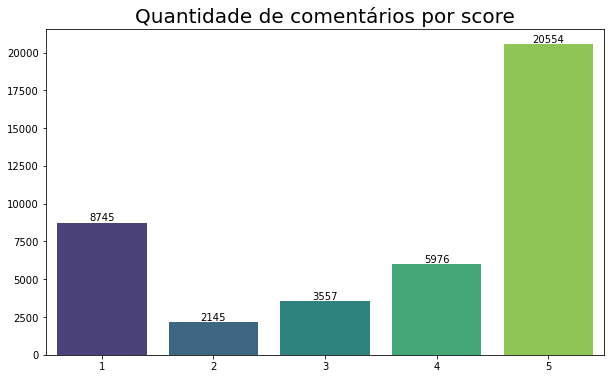

In [9]:
# Criando um datafrem que contem as quantidade de acordo com o score
quantidade = pd.DataFrame(dataset['review_score'].value_counts()).sort_index()

# plotando o gráfico de barra
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.barplot(y='review_score', x=quantidade.index, data=quantidade, orient='v', palette='viridis')
ax.set_title('Quantidade de comentários por score', fontdict={'fontsize': 20})
ax.set(ylabel=None, xlabel=None)
ax.bar_label(ax.containers[0])
plt.show()

Com objetivo de criar um modelo de análise sentimental em uma abordagem de Machine Learning supervisionado, iremos dividir os sentimentos em três classes: negativo, neutro e positivo. O database não possui uma definição explicita sobre a definição de sentimento para cada comentário. Pensando em uma implementação rápida, utilizaremos a coluna "review_score" para rotular os dados nas três classes já que ela dá uma uma ideia sobre a satisfação do cliente a respeito da compra.

Rotulagem dos dados:
- Positivo (1): Compreende os scores de valores 4 e 5
- Neutro (0): Compreende o score de valor 3
- Negativo (-1): Compreende os scores de valores 1 e 2


In [10]:
# Rotulagem dos dados
score_map = {
    1: -1,
    2: -1,
    3: 0,
    4: 1,
    5: 1
}

dataset['sentiment_label'] = dataset['review_score'].map(score_map)
dataset = dataset[['review_score', 'sentiment_label','review_comment_message']]

In [11]:
dataset.head()

,review_score,sentiment_label,review_comment_message
0,5,1,Recebi bem antes do prazo estipulado.
1,5,1,Parabéns lojas lannister adorei comprar pela I...
2,4,1,aparelho eficiente. no site a marca do aparelh...
3,4,1,"Mas um pouco ,travando...pelo valor ta Boa.\r\n"
4,5,1,"Vendedor confiável, produto ok e entrega antes..."


In [12]:
dataset['sentiment_label'].value_counts()

 1    26530
-1    10890
 0     3557
Name: sentiment_label, dtype: int64

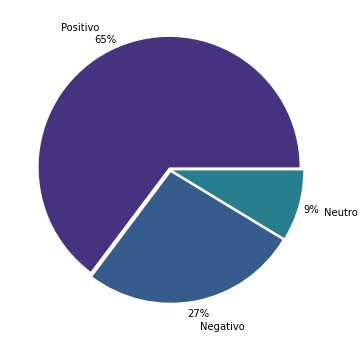

In [13]:
sentiment = pd.DataFrame(dataset['sentiment_label'].value_counts())
labels = ['Positivo', 'Negativo', 'Neutro']

fig, ax = plt.subplots(figsize=(10, 6))
colors = sns.color_palette('viridis')
ax.pie(sentiment['sentiment_label'],labels= labels,autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2, explode = [0.02, 0.02, 0.02], colors=colors)
plt.show()

## 4. Criando uma BaseLine

Iremos definir uma baseline para a acurácia de modelo de classificação de sentimos supervisionado. A baseline é um modelo simples de previsão que atua como referência para futuros modelos de Machine Learning.

### 4.1. Bag of Words: criando representações da linguagem humana.

In [14]:
# Vetorizando as 50 palavras com mais ocorrência da coluna "review_comment_message"
vetorizar = CountVectorizer(max_features=50)
bag_of_words = vetorizar.fit_transform(dataset['review_comment_message'])
bag_of_words.shape

(40977, 50)

In [15]:
# Visualização das 50 palavras com mais ocorrência
print(vetorizar.get_feature_names_out())

['ainda' 'antes' 'as' 'até' 'bem' 'bom' 'chegou' 'com' 'como' 'compra'
 'comprei' 'da' 'de' 'dentro' 'do' 'em' 'entrega' 'entregue' 'estou' 'eu'
 'excelente' 'foi' 'gostei' 'loja' 'mais' 'mas' 'me' 'meu' 'minha' 'muito'
 'na' 'no' 'não' 'os' 'para' 'por' 'prazo' 'produto' 'qualidade' 'que'
 'recebi' 'recomendo' 'rápida' 'super' 'só' 'tudo' 'um' 'uma' 'veio'
 'ótimo']


### 4.2. Modelo: LogisticRegression 

In [16]:
# verificar a proporção do review score
dataset.review_score.value_counts().sort_index()

1     8745
2     2145
3     3557
4     5976
5    20554
Name: review_score, dtype: int64

In [17]:
regressao_logistica = LogisticRegression(solver = "saga", multi_class='multinomial')
scores = cross_val_score(regressao_logistica, bag_of_words, dataset['sentiment_label'], cv=3, scoring="accuracy")
print(f'Scores:{np.sort(scores)}')
print(f'Média: {scores.mean()}')
print(f'Desvio Padrão: {scores.std()}')

Scores:[0.7933963  0.79874076 0.79976572]
Média: 0.7973009249090954
Desvio Padrão: 0.002792518176023985


## 5. Pipeline de trasformação

Será utilizado a classe Pipeline do Scikit Learn para executar uma preparação dos textos de cada comentário de forma automática, deixando pronto para treinamento e previsão do rótulo de sentimento. As etapas do pipeline são:

- Remoção das expressões regulares: sabendo que os dados são fruto de comentários da internet, será necessário lidar com algumas expressões regulares. Iremos realizar o pré-processamento dos dados, substituído as expressões regulares por termos que as caracterizem de forma simples;

- Remoção de StopWords: As stopwords são palavras que não apresentam relevância em determinado contexto e podem ser removidas sem perda semântica da frase;

- Normalização dos comentários: pega os dados Unicode e tenta representá-los em caracteres ASCII (ou seja, os caracteres universalmente exibíveis entre 0x00 e 0x7F), onde os compromissos assumidos ao mapear entre dois conjuntos de caracteres são escolhidos para estar perto do que um humano com um teclado americano escolheria;

- Stemming: Stemming é a técnica que transforma as flexões de uma palavra em um núcleo comum (tronco).  Essa técnica normaliza as palavras de forma a evitar suas flexões e derivações. Existem diversos algoritmos para realizar a “stemmização", seja em Português, sejam em outros idiomas;

- Extração de features: A extração de features de texto envolve resumir automaticamente o texto e encontrar palavras importantes. A extração de palavras poderá ser feita de duas formas:
    - CountVectorizer: converte uma coleção de documentos de texto em uma matriz de contagens de token, ou seja, produz uma representação esparsa das contagens de frequência das palavras ao longo de todo o dataset;
    - TF-IDF (Term Frequency-Inverse Document Frequency): é uma medida estatística que tem o intuito de indicar a importância de uma palavra de um documento em relação a uma coleção de documentos ou em um corpus linguístico.  O TF-IDF irá contar a frequência das palavras e atribui pesos as mesmas, ponderando-as em todo o dataset. Se uma palavra aparece muitas vezes, ela perde o poder de diferenciação, logo, possuirá um peso menor.


Todas as etapas do Pipeline foram modularizadas no diretório utils para tornar o programa mais "limpo".


### 5.1. Analisando os Hiperparâmetros da vetorização (TfidfVectorizer) do Pepiline

#### 5.1.1. N-grams

Os modelos que estávamos utilizando até agora (bag of words), não gera um valor que preserve a sequência de palavras. O N-grams considera essencialmente uma sequência de palavras que aparecem na mesma "janela" ao mesmo tempo. Iremos testar modelos que com a utilização de N-grams:

In [38]:
# lista de n-grams
ngram_range = [(1,2), (2,2), (2,3)]

for ngram in ngram_range:
    vectorizer = TfidfVectorizer(max_features=300, ngram_range=ngram)

    # Criando o Pipeline
    text_pipeline = Pipeline([
        ('regex', RemoverRegex(regex_transformers)),
        ('stopwords', RemoverStopwords(stopwords.words('portuguese'))),
        ('normalization', ProcessoNormalizacao()),
        ('stemming', ProcessoStemming(RSLPStemmer())),
        ('text_features', ExtracaoFeatures(vectorizer))
    ])

    # Dfinido X e y 
    comentarios = dataset['review_comment_message'].dropna().index
    score = dataset['review_score'][comentarios].map({1: 'negativo', 2: 'negativo', 3: 'neutro', 4: 'positivo', 5: 'positivo'})

    # Dfinido X e y 
    X = list(dataset['review_comment_message'][comentarios].values)
    y = score.values

    # Aplicando o pipeline
    X_processed = text_pipeline.fit_transform(X)

    # Dividindo os dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=.20, stratify=dataset['sentiment_label'], random_state=42)

    #Criação do modelo
    regressao_logistica = LogisticRegression(solver = "saga", multi_class='multinomial', random_state=42)
    regressao_logistica.fit(X_train, y_train)
    print(f'Score para n-grams {ngram}: {regressao_logistica.score(X_test, y_test)}')

Score para n-grams (1, 2): 0.8399219131283553
Score para n-grams (2, 2): 0.8035627135187896
Score para n-grams (2, 3): 0.7986822840409956


Para todos os intervalos de n-grams calculados ocorreu acarretou em piora do modelo de classificação. Logo, não há razões para utilização dos n-grams no modelo de predição, já que sua utilização acarreta no aumento de complexidade do modelo, mas não aumenta sua acurácia.

#### 5.1.2. Analisando o max_features, min_df e max_df

- max_features: O hiperparâmetro considera apenas as principais features (palavras ou conjunto de palavras) ordenados por frequência de termo em todo o corpus.
- min_df: O hiperparâmetro define um limite para ignorar os termos que tenham uma frequência de documento estritamente inferior ao limite fornecido.
- max_df: O hiperparâmetro define um limite para ignorar os termos que têm uma frequência de documento estritamente superior ao limite determinado.

In [39]:
# Dfinido X e y 
comentarios = dataset['review_comment_message'].dropna().index
score = dataset['review_score'][comentarios].map({1: 'negativo', 2: 'negativo', 3: 'neutro', 4: 'positivo', 5: 'positivo'})

# Dfinido X e y 
X = list(dataset['review_comment_message'][comentarios].values)
y = score.values

# Criando o Pipeline
text_pipeline = Pipeline([
    ('regex', RemoverRegex(regex_transformers)),
    ('stopwords', RemoverStopwords(stopwords.words('portuguese'))),
    ('normalization', ProcessoNormalizacao()),
    ('stemming', ProcessoStemming(RSLPStemmer()))
    ])

# Aplicando o pipeline
X_processed = text_pipeline.fit_transform(X)

In [40]:
# Função para verificar a acuracia dos melhores valores de hiperparamentros
def hiperparamentros_tfidfVectorizer(max_features, min_df, max_df):
    col=['max_features', 'min_df', 'max_df', 'score']
    list = []
    for maxfeatures in max_features:
        for mindf in min_df:
            for maxdf in max_df:
                vectorizer = TfidfVectorizer(max_features=maxfeatures, min_df=mindf, max_df=maxdf)

                X = vectorizer.fit_transform(X_processed)

                # Dividindo os dados em treino e teste
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, stratify=dataset['sentiment_label'], random_state=42)

                #Criação do modelo
                regressao_logistica = LogisticRegression(solver = "saga", multi_class='multinomial', random_state=42)
                regressao_logistica.fit(X_train, y_train)
                score = regressao_logistica.score(X_test, y_test)
                list.append([maxfeatures, mindf, maxdf, score])
    return pd.DataFrame(list, columns=col).sort_values('score', ascending=False).reset_index(drop=True)

In [41]:
max_features = [200, 300, 400, 500]
min_df = [0.05, 0.2, 0.3]
max_df = [0.8, 0.9, 0.95]

df_score = hiperparamentros_tfidfVectorizer(max_features, min_df, max_df)
df_score.head(10)

,max_features,min_df,max_df,score
0,200,0.05,0.80,0.793436
1,300,0.05,0.90,0.793436
2,500,0.05,0.95,0.793436
3,500,0.05,0.90,0.793436
4,500,0.05,0.80,0.793436
5,400,0.05,0.95,0.793436
6,400,0.05,0.90,0.793436
7,200,0.05,0.90,0.793436
8,300,0.05,0.95,0.793436
9,400,0.05,0.80,0.793436


É possível perceber que para os dez maiores valores de score calculado são para o min_df igual a 0.05, independente das variações dos outros hiperparâmetros. Então, vamos reajustar o valor de min_df e calcular novamente os valores de acurácia.

In [42]:
max_features = [200, 300, 400, 500]
min_df = [0, 0.01, 0.05]
max_df = [0.7, 0.8, 0.9]

df_score = hiperparamentros_tfidfVectorizer(max_features, min_df, max_df)
df_score.head(10)

,max_features,min_df,max_df,score
0,500,0.0,0.9,0.842240
1,500,0.0,0.8,0.842240
2,500,0.0,0.7,0.842240
3,400,0.0,0.7,0.839678
4,300,0.0,0.8,0.839678
5,400,0.0,0.9,0.839678
6,400,0.0,0.8,0.839678
7,300,0.0,0.9,0.839678
8,300,0.0,0.7,0.839678
9,200,0.0,0.8,0.837360


Então, é possível visualizar as seguintes afirmações:
- Quanto menor o valor min_df melhor é acuracia do modelo;
- Quanto maior o valor max_features melhor é acuracia do modelo;
- O valor de max_df não contribuiu para melhora da acurácia para esse conjunto de hiperparâmetros.

In [43]:
max_features = [500, 600, 700]
min_df = [0, 0.001, 0.005]
max_df = [0.7, 0.8, 0.9]

df_score = hiperparamentros_tfidfVectorizer(max_features, min_df, max_df)
df_score.head(20)

,max_features,min_df,max_df,score
0,700,0.000,0.9,0.844802
1,700,0.000,0.8,0.844802
2,700,0.000,0.7,0.844802
3,700,0.001,0.9,0.844314
4,700,0.001,0.8,0.844314
5,700,0.001,0.7,0.844314
6,600,0.001,0.8,0.843948
7,600,0.001,0.9,0.843948
8,600,0.001,0.7,0.843948
9,600,0.000,0.7,0.843582


Aumentar o valor de features para melhora do modelo de classificação não resultou em grande melhora da acurácia (score) do modelo, mas em contrapartida aumento sua complexidade. Então vamos escolher o melhor conjunto de hiperparâmetros para o max_features igual a 500. É possível perceber que nove diferentes combinações obtiveram um score de 0,84224. Logo, vamos escolher o maior valor de min_df e o menor valor de max_df para tentar tornar o modelo mais genérico.

In [44]:
df_score[df_score['max_features'] == 500]

,max_features,min_df,max_df,score
12,500,0.000,0.8,0.84224
13,500,0.000,0.7,0.84224
14,500,0.001,0.9,0.84224
15,500,0.001,0.8,0.84224
16,500,0.001,0.7,0.84224
17,500,0.000,0.9,0.84224
18,500,0.005,0.9,0.83797
22,500,0.005,0.8,0.83797
23,500,0.005,0.7,0.83797


Valores de hiperparâmetros selecionados:
- max_features = 500
- min_df = 0.001
- max_df = 0.7

### 5.1. Definindo o Pipeline de trasformação

In [18]:
# Definindo todas as trafomações regex para serem aplicadas ao pipeline
regex_transformers = {
    'datas': re_dates,
    'valores_dinheiro': re_money,
    'numeros': re_numbers,
    'negacoes': re_negation,
    'caracteres_especiais': re_special_chars,
    'espacos_branco': re_whitespaces
}

vectorizer = TfidfVectorizer(max_features=500, min_df=0.001, max_df=0.7) 

# Criando o Pipeline
text_pipeline = Pipeline([
    ('regex', RemoverRegex(regex_transformers)),
    ('stopwords', RemoverStopwords(stopwords.words('portuguese'))),
    ('normalization', ProcessoNormalizacao()),
    ('stemming', ProcessoStemming(RSLPStemmer())),
    ('text_features', ExtracaoFeatures(vectorizer))
])


### 5.2. Separando os dados em treino e teste

In [19]:
# Dfinido X e y 
comentarios = dataset['review_comment_message'].dropna().index
score = dataset['review_score'][comentarios].map({1: 'negativo', 2: 'negativo', 3: 'neutro', 4: 'positivo', 5: 'positivo'})

# Dfinido X e y 
X = list(dataset['review_comment_message'][comentarios].values)
y = score.values

# Aplicando o pipeline
X_processed = text_pipeline.fit_transform(X)

## 6. Modelos de Classificação de Sentimento

### 6.1. Recalculando a Baseline

#### 6.1.1. Acurácia 

Utilizaremos a função cross_val_score() para avaliar o modelo LogisticRegression com a utilização da validação cruzada K-fold com três partes. Lembre-se de que a validação cruzada K-fold significa dividir o conjunto de treinamento em K-folds (neste caso, três), prever e avaliar as previsões em cada conjunto utilizando um modelo treinado em conjuntos restantes.

In [20]:
regressao_logistica = LogisticRegression(solver = "saga", multi_class='multinomial')
scores = cross_val_score(regressao_logistica, X_processed, y, cv=3, scoring="accuracy")
print(f'Scores:{np.sort(scores)}')
print(f'Média: {scores.mean()}')
print(f'Desvio Padrão: {scores.std()}')

Scores:[0.84017864 0.84318032 0.84405886]
Média: 0.8424726065841814
Desvio Padrão: 0.001661260943955625


Comparando os valores dos scores obtido e com os valores da baseline antes do tratamento dos dados é possível perceber um ganho de 4.7% na acurácia do modelo utilizando os mesmos hiperparâmetros para o modelo.

#### 6.1.2. Matriz de confusão

O método cross_val_predict() desempenha a validação cruzada K-fold, mas, em vez de retornar as pontuações da avaliação, ela retorna as previsões feitas em cada parte do teste. Isso significa que você obtém uma previsão limpa para cada instância no conjunto de treinamento (“limpa”, significando que a previsão é feita por um modelo que nunca viu os dados durante o treinamento).

In [22]:
y_pred = cross_val_predict(regressao_logistica, X_processed, y, cv=3)
conf_matrix = confusion_matrix(y, y_pred)

<AxesSubplot:>

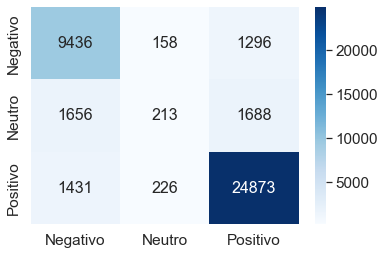

In [74]:
df_cm = pd.DataFrame(conf_matrix, index=['Negativo', 'Neutro', 'Positivo'], columns=['Negativo', 'Neutro', 'Positivo'])
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="Blues", fmt='g')

Cada linha em uma matriz de confusão representa uma classe real, enquanto a coluna representa uma classe prevista. A partir da matriz de confusão podemos visualizar:
- 1º linha da matriz considera reviews Negativos: 9436 reviews foram correamente classificados como negativos, enquanto 158 foram classificados como neutros e 1296 como positivos.
- 2º linha da matriz considera reviews neutros: 213 reviews foram correamente classificados como neutros, enquanto 1656 foram classificados como negativos e 1688 como positivos.
- 3º linha da matriz considera reviews Positivos: 24873 reviews foram correamente classificados como positivos, enquanto 1431 foram classificados como negativos e 226 como neutros.

#### 6.1.3. Precisão e Revocação

A metrica presição do classificador (precision_score) é a acurácia das previsões positivas. O melhor valor é 1 e o pior valor é 0.

$$ precisão = \frac {TP}{TP + FP} $$

- TP: número de verdadeiros positivos
- FP: número de falsos positivos

A precisão é utilizada em conjunto com outra métrica chamada revocação (recall_score), também conhecida como sensibilidade ou taxa de verdadeiros positivos (TPR, do inglês): esta é a taxa de instâncias positivas que são corretamente detectadas pelo classificador.

$$ revocacão = \frac {TP}{TP + FN} $$

- TP: número de verdadeiros positivos
- FN: número de falsos negativos

In [78]:
'''
'weighted':
Calcule as métricas para cada rótulo e encontre sua média ponderada pelo suporte 
(o número de instâncias verdadeiras para cada rótulo). Isso altera 'macro' para 
levar em conta o desequilíbrio do rótulo; pode resultar em um F-score que não está 
entre precisão e recuperação.
'''
precisao = precision_score(y, y_pred, average='weighted')
revocacao = recall_score(y, y_pred, average='weighted')
print(f'Precisão: {precisao:.4f}')
print(f'Revocação: {revocacao:.4f}')

Precisão: 0.8093
Revocação: 0.8425


É possível perceber que o valor de precisão obtido foi de 0.8093, se comparada com o valor do score médio (0.8425) houve uma redução bastante expressiva. O valor de precisão nos indica que quando um review é classificado, ele estará com a classificação correta, em média, aproximadamente 81% das vezes das previsões positivas. Já a taxa de instâncias postivias que são corretamente detectadas pelo classificador é igual a 84%.

#### 6.1.4. Pontuação F1

Uma forma simples de comparar dois classificadores é através da métrica chamada pontuação (F1). A pontuação F1 é a média harmônica da precisão e revocação. Enquanto a média regular trata igualmente todos os valores, a média harmônica dá muito mais peso aos valores mais baixos. Como resultado, o classificador só obterá uma pontuação F1 alta se a revocação e a precisão forem altas.

$$F_1 = \frac {2}{\frac {1}{precisão} + \frac {1}{revocacão}} = \frac {precisão x revocacão} {precisão + revocacão} = \frac {TP} {TP + \frac {FN + FP} {2}}

In [23]:
f1 = f1_score(y, y_pred, average='weighted')
print(f'Precisão: {f1:.4f}')

Precisão: 0.8153


### 6.3. LogisticRegression

Alguns algoritmos de regressão também podem ser utilizados para classificação (e vice-versa). A Regressão Logística (também chamada de Regressão Logit) é comumente utilizada para estimar a probabilidade de uma instância pertencer a uma determinada classe. Assim como um modelo de Regressão Linear, um modelo de Regressão Logística calcula uma soma ponderada das características de entrada (mais um termo de polarização), mas, em vez de gerar o resultado diretamente como o modelo de Regressão Linear, gera a logística desse resultado.

O modelo de Regressão Logística pode ser generalizado para suportar múltiplas classes diretamente sem a necessidade de treinar e combinar vários classificadores binários. Isso é chamado Regressão Softmax, ou Regressão Logística Multinomial. A ideia é bem simples: quando dada uma instância x, o modelo de Regressão Softmax primeiro calcula uma pontuação sk(x) para cada classe k, então estima a probabilidade de cada classe aplicando a função softmax (também chamada exponencial normalizada) às pontuações.

Uma vez calculada a pontuação de cada classe para a instância x, você pode estimar a probabilidade Pk de a instância pertencer à classe k ao executar as pontuações através da função softmax: ela calcula a exponencial de cada pontuação e a normaliza (dividindo pela soma de todas as exponenciais). Assim como o classificador de Regressão Logística, o classificador de Regressão Softmax prevê a classe com a maior probabilidade estimada (que é simplesmente a classe com a maior pontuação)

### 6.3. SVM